## Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


### Steps to take:

##### Train classifier
1. load dataset
2. extract features from dataset - play with different feature parameters and combinations
3. scale features using StandardScaler()
4. split data into train and test set
5. train classifier and test accuracy - linear SVC and other - Important is only the time to predict not the time to train since this happens only once. Maybe do RandomizedSearchCV or GridSearchCV

##### Build pipeline for video processing
6. whole image HOG (or sliding window)
7. extract same exact features as before from every search window
8. scale features using same scaler
9. predict using classifier (and print found windows onto test images)
10. add heat to heatmap
11. integrate over several video frames and threshold
12. use label() to get boxes to draw and draw


In [1]:
# Import statements
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from sklearn.externals import joblib
import os
from sklearn.decomposition import PCA


#%matplotlib qt
%matplotlib inline

In [34]:
# Helper function to load data set

def load_dataset(subset=None):
    images = glob.glob('./dataset/vehicles/*/*.png')
    cars = []
    for image in images:
        cars.append(image)

    notcars = []
    images = glob.glob('./dataset/non-vehicles/*/*.png')
    for image in images:
        notcars.append(image)

    if subset != None:
        cars = cars[0:subset]
        notcars = notcars[0:subset]
   
    return cars, notcars

cars, notcars = load_dataset(subset=100)

print('Dataset loaded! Number of car samples:', len(cars), '. Number of non-car samples:', len(notcars))

Dataset loaded! Number of car samples: 100 . Number of non-car samples: 100


In [38]:
# Helper function to print two images side by side

def print_example_images(img, img2):
    plt.figure(figsize=(17,5))
    
    plt.subplot(121), plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap='gray')
        
    plt.subplot(122), plt.xticks([]), plt.yticks([])
    plt.imshow(img2, cmap='gray')
        
    plt.show()

def save_image(img, name):
    mpimg.imsave( "./output_images/"+ name + ".jpg", img)

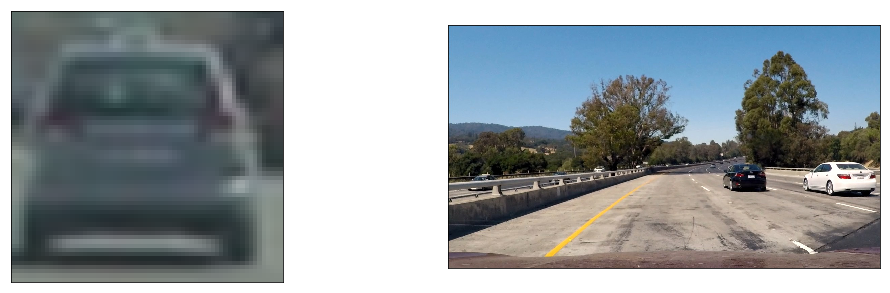

0.349341 0.49899853622


In [31]:
# Helper to load jpg and png images. Automatically adjusts the scaling
    
def load_image(path):
    
    img = mpimg.imread(path)
    
    if img.mean() > 2:
        img = img/255
    
    return img

img_png = load_image(cars[4])
img_jpg = load_image('./test_images/test1.jpg')
print_example_images(img_png, img_jpg)
print(img_png.mean(), img_jpg.mean())


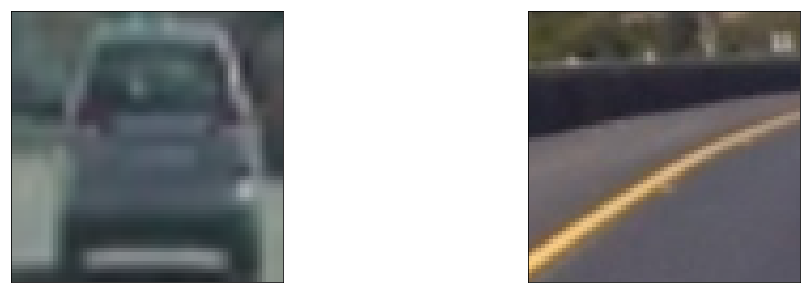

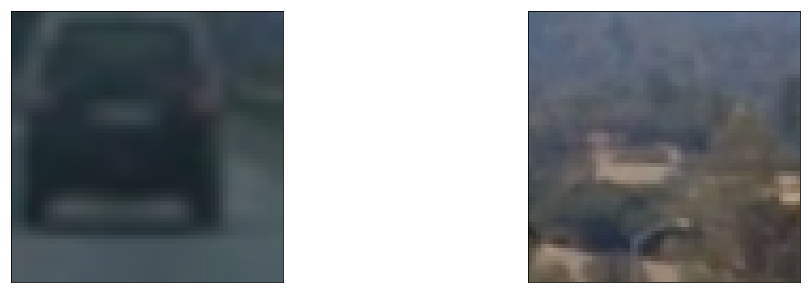

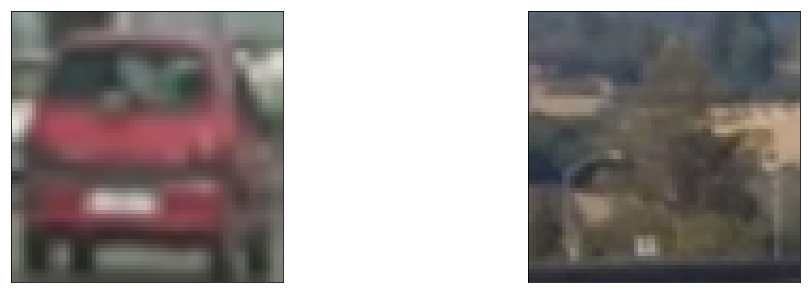

In [40]:
# Expore dataset

for n in range(3):
    rand = np.random.randint(0, 100)
    img_car = load_image(cars[rand])
    img_notcar = load_image(notcars[rand])
    print_example_images(img_car, img_notcar)

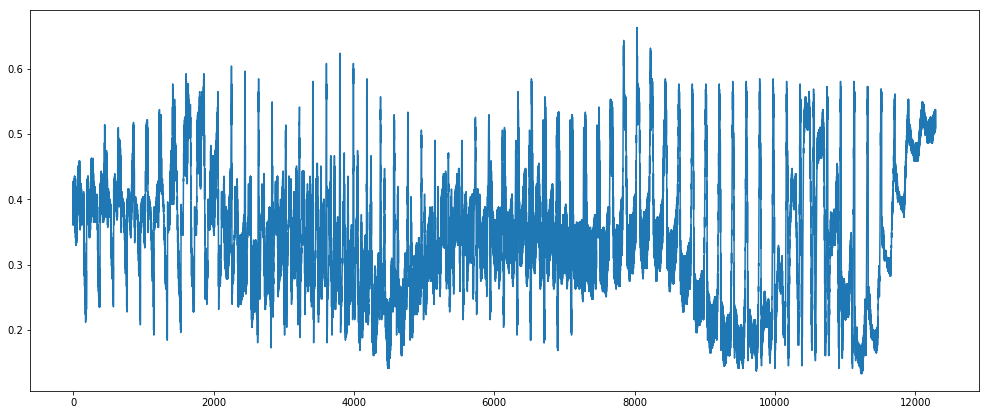

In [41]:
## Helper function to visualize the feature vector

def visualize_features(features):
    plt.figure(figsize=(17,7))
    plt.plot(features)
    plt.show()
    return


## Demo
img = load_image(cars[4])
visualize_features(img.ravel())

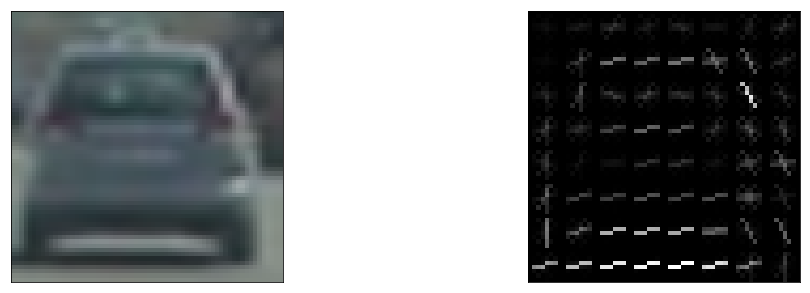

Shape of HOG feature vector:  (1764,)


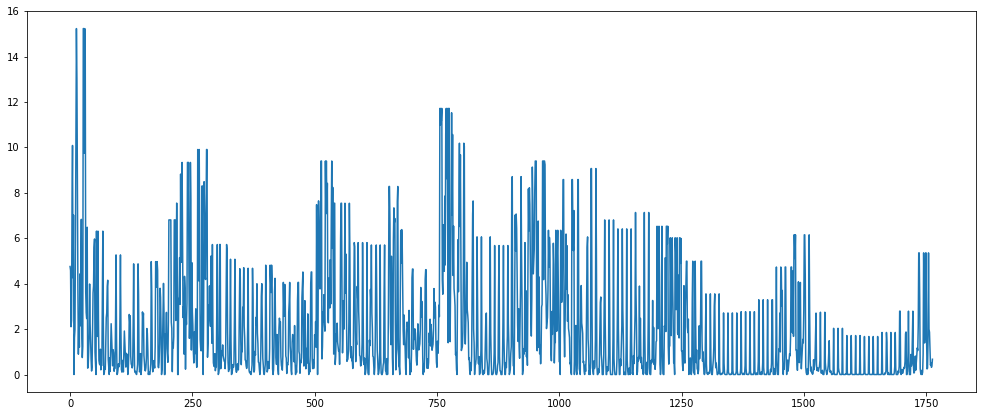

In [45]:
# Helper function to extract HOG features and optional visualization

def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixel_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixel_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

    
## Demo
img = load_image(cars[4])
orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

print_example_images(img, hog_image)
print('Shape of HOG feature vector: ',features.shape)
visualize_features(features)

Shape of color feature vector:  (768,)


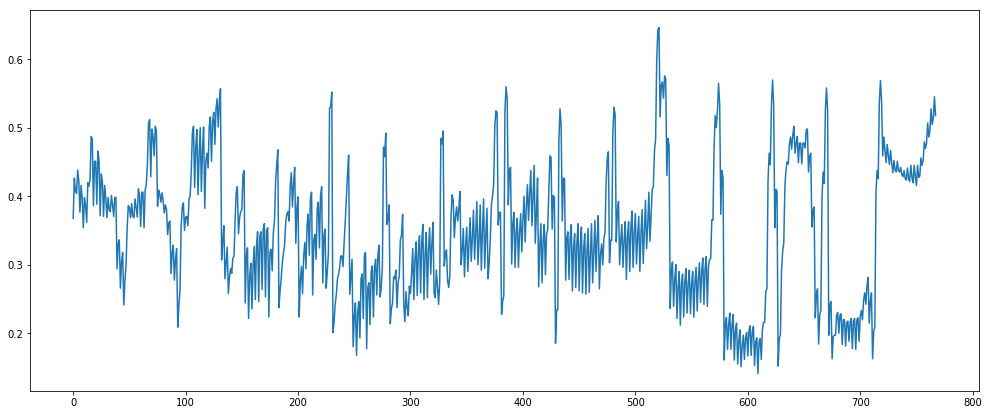

In [29]:
# Helper function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Resize image and flatten it
    features = cv2.resize(img, size).ravel()
    return features

## Demo
img = load_image(cars[4])
spatial_size = (16, 16)  # Spatial binning dimensions

features = bin_spatial(img, size=spatial_size)
print('Shape of color feature vector: ',features.shape)
visualize_features(features)

(192,)


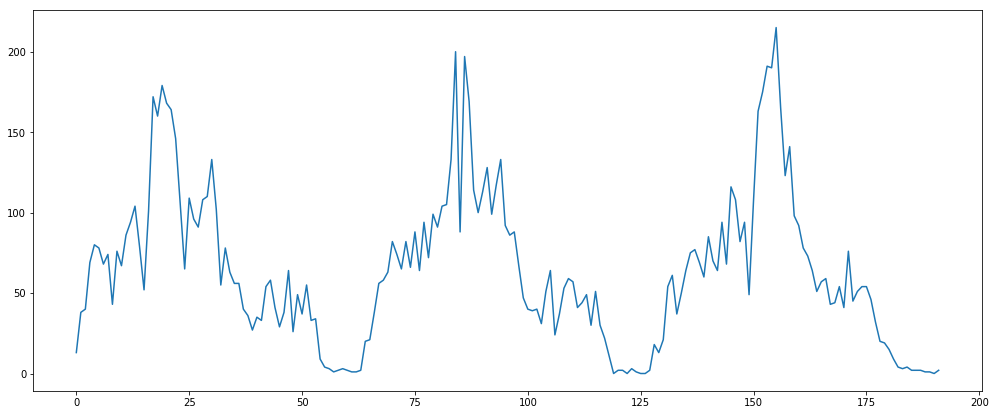

In [8]:
# Helper function to compute color histogram features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

## Demo
img = load_image(cars[4])
hist_bins = 64  # Number of histogram bins

features = color_hist(img, nbins=hist_bins)
print(features.shape)
visualize_features(features)

Shape of combined feature vector:  (2544,)


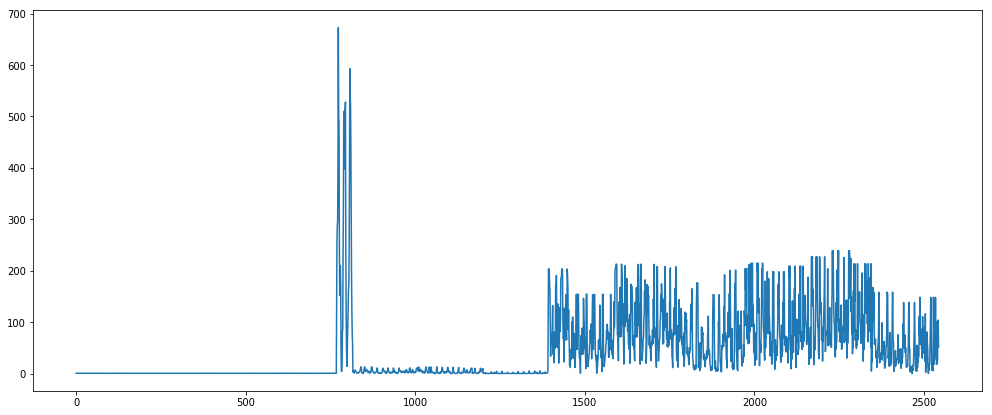

In [50]:
# Helper function to wrap the extraction of spatial, histogram and hog features

def extract_features(file, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=-1,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    file_features = []
    
    # Read in image
    image = load_image(file)

    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    else:
        feature_image = np.copy(image)
        
    # extract spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    
    # extract histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    
    # extract hog features
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == -1:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
    # Return feature vector
    return np.concatenate(file_features)

## Demo
sample = cars[4]
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 16  # HOG pixel per cell
cell_per_block = 2  # HOG cells per block
hog_channel = -1  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

features = extract_features(sample, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

print('Shape of combined feature vector: ',features.shape)
visualize_features(features)

In [78]:
# Helper function to iterate over dataset 

def extract_features_from_dataset(files, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in tqdm(files):
        file_features = extract_features(file, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
        features.append(file_features)
        
    # Return list of feature vectors
    return features


## Demo
car_features = extract_features_from_dataset(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_from_dataset(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)


100%|█████████████████████████████████████| 8968/8968 [00:38<00:00, 235.77it/s]


Train and test feature set generated. Shape of train set: (14208, 2544)


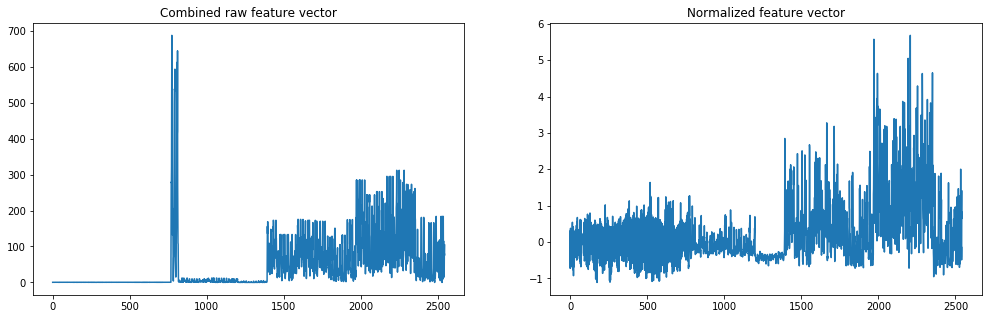

In [79]:
# Helper function to create dataset and normalize the features
def create_and_scale_trainset(car_features, notcar_features):
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Train and test feature set generated. Shape of train set:', X_train.shape)
    
    return X_scaler, X_train, X_test, y_train, y_test


## Demo

X_scaler, X_train, X_test, y_train, y_test = create_and_scale_trainset(car_features, notcar_features)

sample_features = car_features[4]

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.title('Combined raw feature vector')
plt.plot(sample_features)
plt.subplot(122)
plt.title('Normalized feature vector')
plt.plot(X_scaler.transform(sample_features))
plt.show()

In [82]:
# Helper function to apply PCA to feature vector

def fit_PCA(X_train, X_test, y_train, y_test, n_components=150):

    # Extracting the top (n_components) eigenfeatures
    pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True).fit(X_train)

    # only for visualization!
    #eigenfaces = pca.components_.reshape((n_components, h, w))

    #Projecting the input data on the eigenfaces orthonormal basis
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    #print("Variance of the PCs: ", pca.explained_variance_ratio_)
    
    print('PCA Train features generated. Shape of PCA train set: ', X_train_pca.shape)
    return pca, X_train_pca, X_test_pca


## Demo
pca, X_train_pca, X_test_pca = fit_PCA(X_train, X_test, y_train, y_test, n_components=150)

PCA Train features generated. Shape of PCA train set:  (14208, 150)


In [60]:
def fit_SVM(X_train, X_test, y_train, y_test, kernel='linear', C=1.0):
    
    # Instanziate Support Vector Machine classifier
    svc = SVC(kernel=kernel, C=C, gamma=0.005)
    # Log the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    time_fit = round(t2 - t, 5)

    # Log accuracy on test set
    accuracy = round(svc.score(X_test, y_test), 4)
    
    # Log prediction time as another performance indicator
    len_test = len(X_test)
    t = time.time()
    prediction = svc.predict(X_test)
    t2 = time.time()
    time_prediction = round((t2 - t)/len_test*100, 6)
    
    return svc, accuracy, time_fit, time_prediction


## Demo
kernel = 'linear'
C = 1.0

svc_pca, accuracy, time_fit, time_prediction = fit_SVM(X_train_pca, X_test_pca, y_train, y_test, kernel=kernel, C=C)
print('Accuracy:',accuracy)
print('Time to fit:', time_fit,'seconds. Time to predict 100 samples: ',time_prediction,'seconds.')

Accuracy: 1.0
Time to fit: 0.002 seconds. Time to predict 100 samples:  0.0 seconds.


# Load dataset, extract features and fit classifier

In [87]:
# Cell loads data set, extracts features and fits classifier
# for later use in video processing pipeline

color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 16  # HOG pixel per cell
cell_per_block = 2  # HOG cells per block
hog_channel = -1  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
kernel = 'rbf'
C = 10
pca_num = 150


# Load previous classifier
if os.path.exists('SSP.pkl'):
    svc, X_scaler, pca = joblib.load('SSP.pkl')
    print(svc)
    print(pca)
    print('Previous classifier and scaler loaded!')

# load, extract, normalize, pca and fit.
else:
    cars, notcars = load_dataset(subset=None)

    car_features = extract_features_from_dataset(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features_from_dataset(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    X_scaler, X_train, X_test, y_train, y_test = create_and_scale_trainset(car_features, notcar_features)
    pca, X_train_pca, X_test_pca = fit_PCA(X_train, X_test, y_train, y_test, n_components=pca_num)
    svc, accuracy, time_fit, time_prediction = fit_SVM(X_train_pca, X_test_pca, y_train, y_test, kernel=kernel, C=C)
    
    joblib.dump((svc,X_scaler,pca), 'SSP.pkl')
    print('Classifier and scaler saved to disk!')
        
    print('Accuracy:',accuracy)
    print('Time to fit:', time_fit,'seconds. Time to predict 100 samples: ',time_prediction,'seconds.')

100%|█████████████████████████████████████| 8968/8968 [00:39<00:00, 228.22it/s]


Train and test feature set generated. Shape of train set: (14208, 2544)
PCA Train features generated. Shape of PCA train set:  (14208, 150)
Classifier and scaler saved to disk!
Accuracy: 0.9969
Time to fit: 5.46786 seconds. Time to predict 100 samples:  0.024866 seconds.


# Vehicle Detection Pipeline

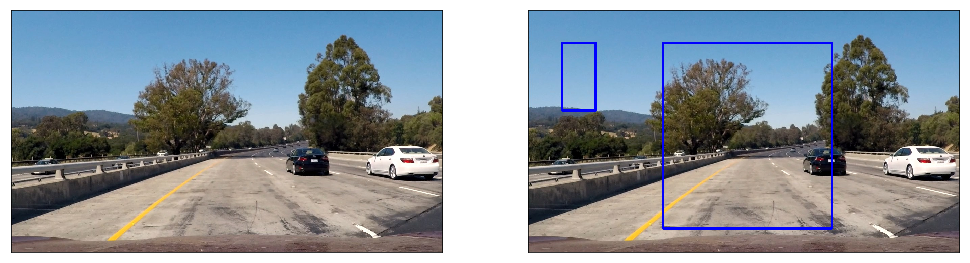

In [88]:
## Helper function to draw boxes on image

def draw_boxes(img, bboxes, color=(0, 0, 1), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Demo
img = load_image('./test_images/test1.jpg')
bboxes = [((100, 100), (200, 300)), ((400, 100), (900, 650))]
result = draw_boxes(img, bboxes)

print_example_images(img, result)

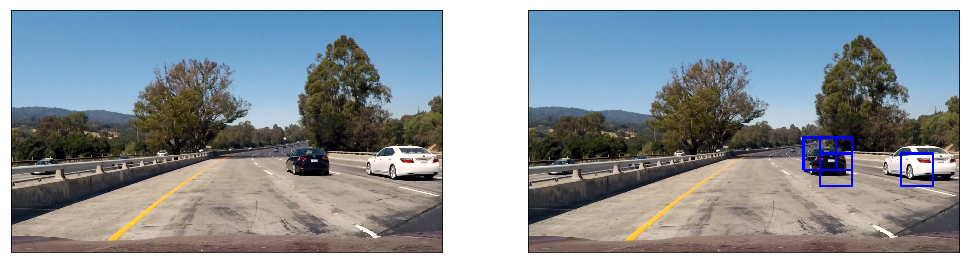

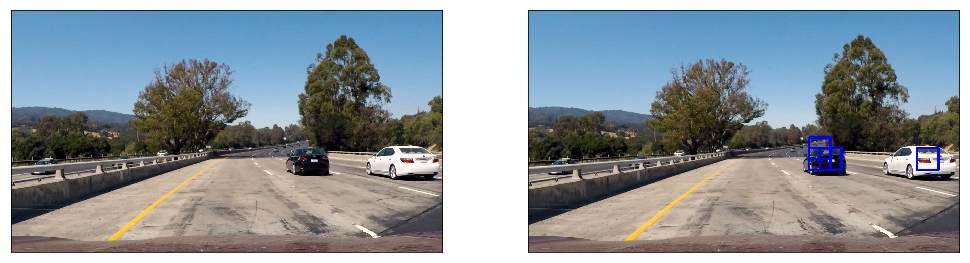

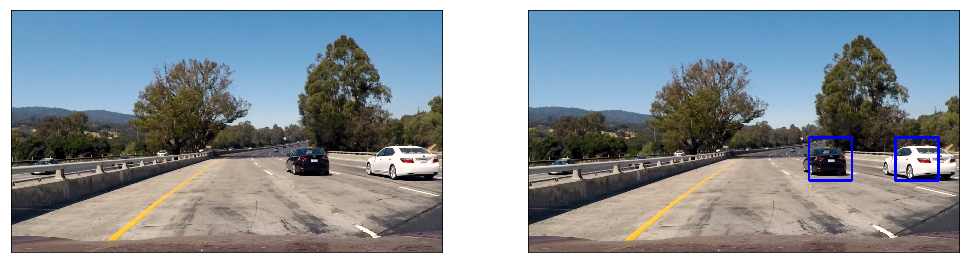

In [94]:
# Function to find cars on an image
# 1. Scale image to a desired size
# 2. Calculate HOG features over whole image
# 3. Subsample in windows of 64x64 pixel
# 4. Calculate color and histogram features on same subsample
# 5. Combine feature vectors
# 6. Normalize and apply PCA
# 7. Predict using previously trained classifier
# 8. Return coordinates of subsamples with predicted cars

### Please note that this code is adopted from the lesson material.

def find_cars(img, ystart, ystop, scale, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    # scale image
    img = img.astype(np.float32)

    # drop upper part of image
    img_tosearch = img[ystart:ystop, :, :]
    # convert color
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    # scale single picture hog to new size
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
 
            test = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features_pca = pca.transform(test_features)
            test_prediction = svc.predict(test_features_pca)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bbox_list.append([(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)])

    return bbox_list


## Demo

ystart = 380

img = load_image('./test_images/test1.jpg')
bbox_list1 = find_cars(img, ystart, 620, 1.5, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print_example_images(img, draw_boxes(img, bbox_list1))
bbox_list2 = find_cars(img, ystart, 530, 1, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print_example_images(img, draw_boxes(img, bbox_list2))
bbox_list3 = find_cars(img, ystart, 656, 2, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print_example_images(img, draw_boxes(img, bbox_list3))

bbox_list = bbox_list1 + bbox_list2 + bbox_list3

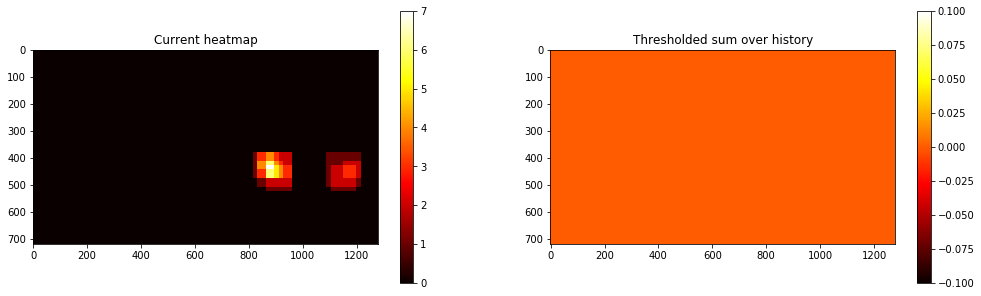

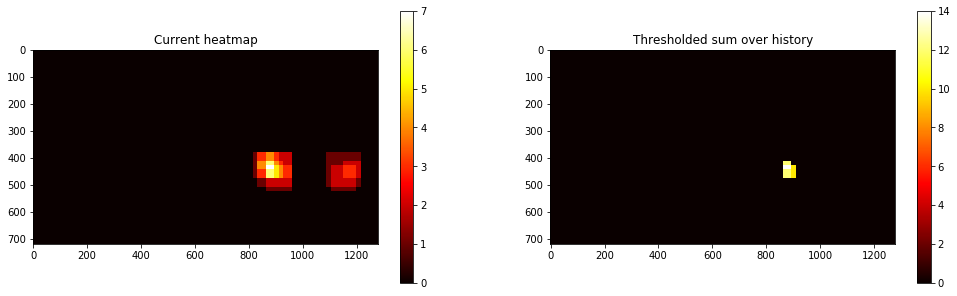

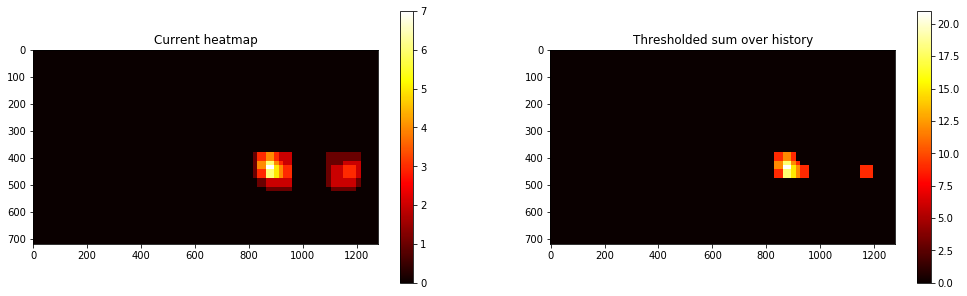

(3, 720, 1280)


In [110]:
# Class to implement heatmap history

class Heatmap():
    def __init__(self, history_depth=10, threshold=2):
        
        self.threshold = threshold
        self.history_depth = history_depth
        self.history = np.array([[],[]])
        self.current_heatmap = np.array([[],[]])
        self.smoothed_heatmap = np.array([[],[]])
        
        
    def add_heat(self, bbox_list):
        self.current_heatmap = np.zeros((720, 1280)).astype(np.uint8)
        for box in bbox_list:
            self.current_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
       
        self.__update_history()
        
        
    def __update_history(self):
        # update history
        if self.history.size == 0:
            self.history = self.current_heatmap.reshape(1,720,1280)
        else:
            self.history = np.vstack((self.history, self.current_heatmap.reshape(1,720,1280)))

        # limit depth of history to 10 newest 
        if self.history.shape[0] > self.history_depth:
            self.history = self.history[1:,:,:]
        
        # calculate sum over history
        self.smoothed_heatmap = np.sum(self.history,axis=0)
        
        # apply threshold to reject false positives
        self.smoothed_heatmap[self.smoothed_heatmap <= self.threshold] = 0
        self.smoothed_heatmap = np.clip(self.smoothed_heatmap, 0, 255)
        
        
## Demo
h = Heatmap(history_depth = 4, threshold = 8)

for n in range(3):
    h.add_heat(bbox_list)
    plt.figure(figsize=(17,5))
    plt.subplot(121)
    plt.title('Current heatmap')
    plt.imshow(h.current_heatmap, cmap='hot')
    plt.colorbar()
    plt.subplot(122)
    plt.title('Thresholded sum over history')
    plt.imshow(h.smoothed_heatmap, cmap='hot')
    plt.colorbar()
    plt.show()

    
    
print(h.history.shape)

2 cars found


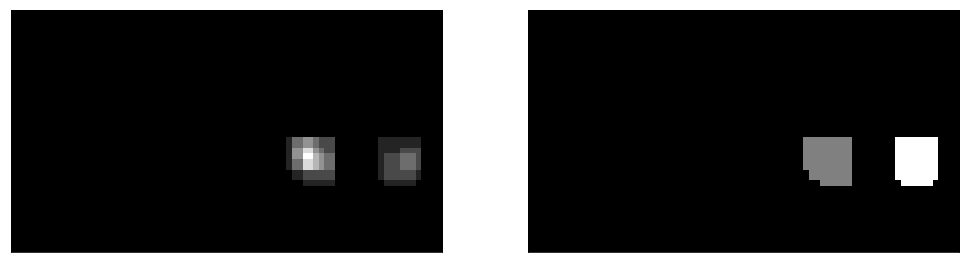

In [114]:
# Function to label features in heatmap
from scipy.ndimage.measurements import label

labels = label(h.current_heatmap)


## Demo
print(labels[1], 'cars found')
print_example_images(h.current_heatmap, labels[0])

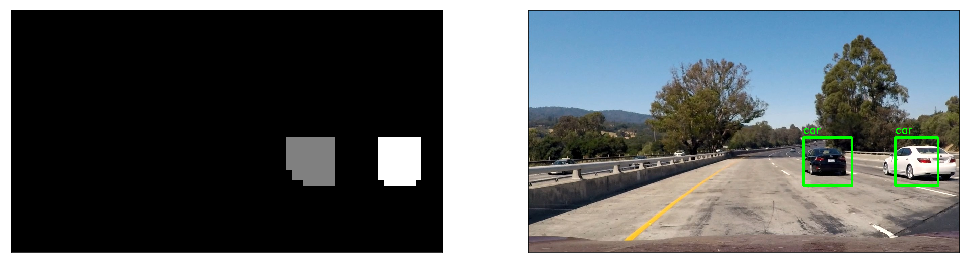

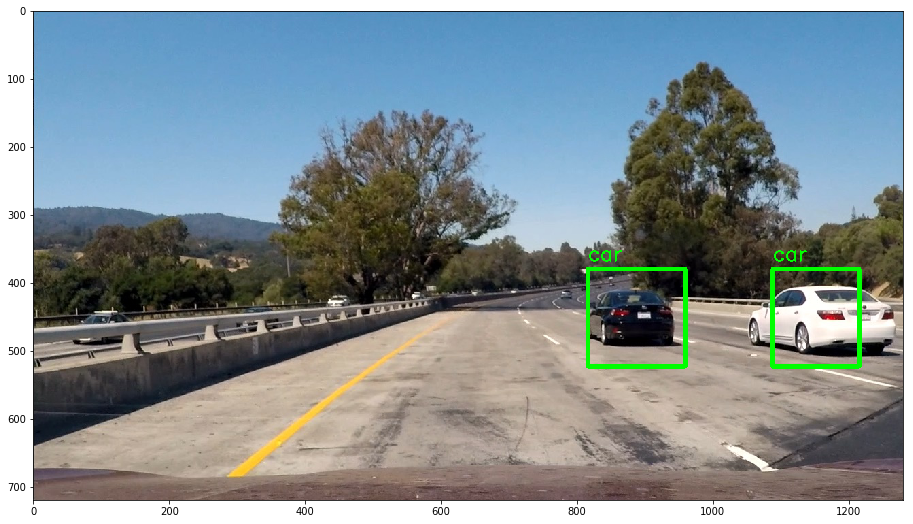

In [122]:
# Helper function to draw boxes around the detected labels

def draw_labeled_bboxes(img, labels, color=(0,1,0)):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixel with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixel
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        bbox = ((xmin, ymin), (xmax, ymax))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'car'
        cv2.putText(img,text, (xmin,ymin-12), font, 1, (0,1,0),2)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
print_example_images(labels[0], draw_img)
plt.figure(figsize=(17,9))
plt.imshow(draw_img, cmap='gray')
plt.show()

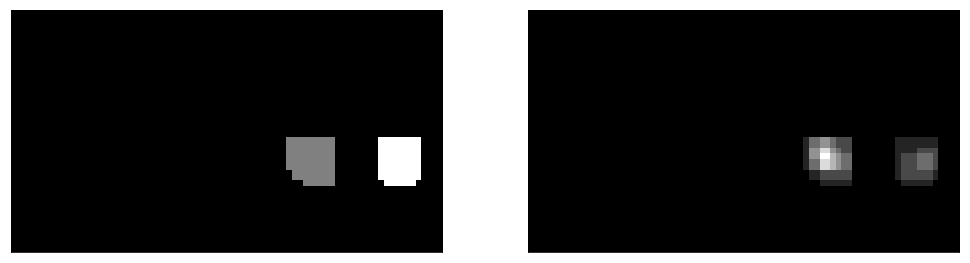

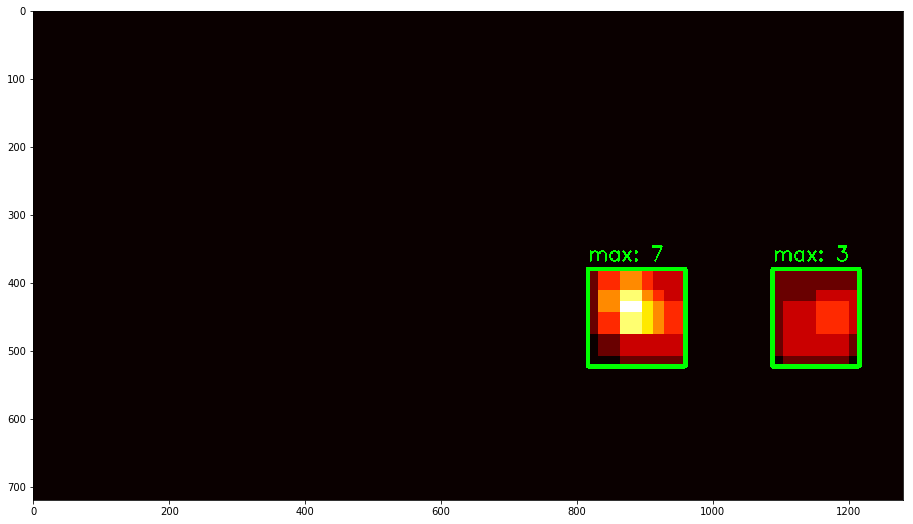

In [128]:
# Helper function to annotate heatmap for debugging purposes

def annotate_heatmap(img, heatmap, labels, color=(0,0,1)):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixel with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixel
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        bbox = ((xmin, ymin), (xmax, ymax))
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'max: ' + str('{:d}'.format(heatmap[ymin:ymax,xmin:xmax].max())) 
        cv2.putText(img,text, (xmin,ymin-12), font, 1, (0,1,0),2)
        
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
        
    # Return the image
    return img


## Demo
cmap = plt.get_cmap('hot')
heatmap_out = h.current_heatmap/h.current_heatmap.max()
heatmap_rgb = cmap(heatmap_out)[:,:,0:3]

draw_img = annotate_heatmap(np.copy(heatmap_rgb), h.current_heatmap, labels, color=(0,1,0))
# Display the image
print_example_images(labels[0], h.current_heatmap)

plt.figure(figsize=(17,9))
plt.imshow(draw_img, cmap='gray')
plt.show()

# Pipeline

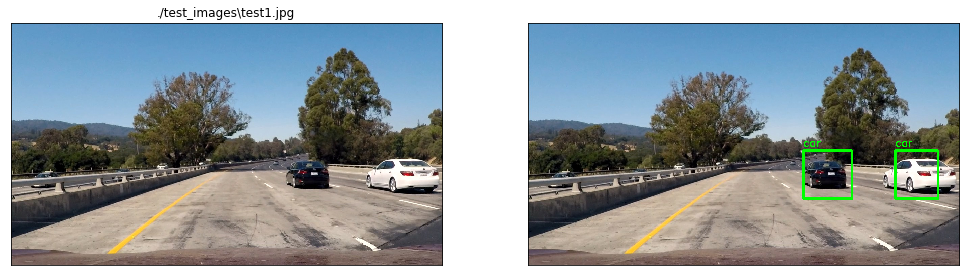

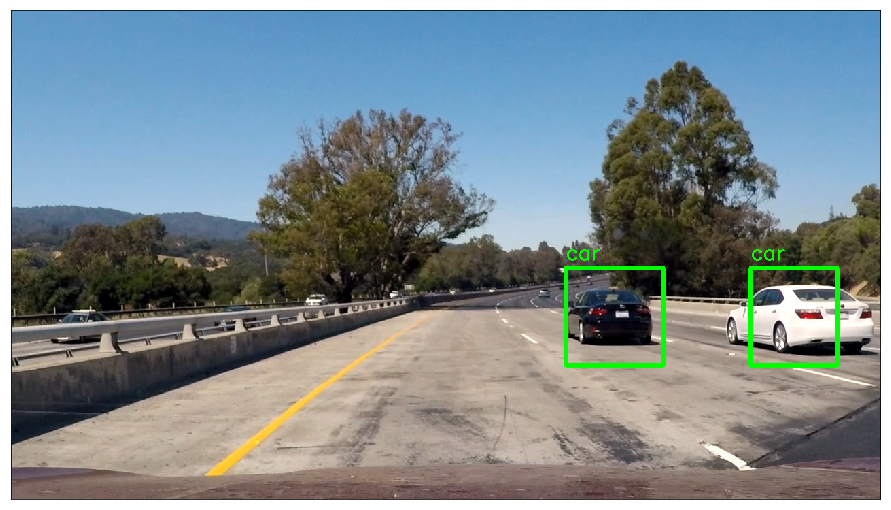

In [161]:
# Image pipeline

def pipeline_vehicle_detection(img, debug=False, video=False):
    
    img = img.astype(np.float32)/255
    
    bbox_list1 = find_cars(img, 380, 620, 1.5, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list2 = find_cars(img, 380, 530, 1, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bbox_list3 = find_cars(img, 380, ystop, 2, svc, pca, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heatmap.add_heat(bbox_list1 + bbox_list2 + bbox_list3)
    
    labels = label(heatmap.smoothed_heatmap)

    result = draw_labeled_bboxes(np.copy(img), labels)
    
    if debug: 
        result = np.vstack((img, result)) # put input image and resulting image on top of each other
        
        cmap = plt.get_cmap('hot')
        heatmap_out = heatmap.smoothed_heatmap/heatmap.smoothed_heatmap.max()
        heatmap_rgb = cmap(heatmap_out)[:,:,0:3]
        heatmap_rgb = annotate_heatmap(np.copy(heatmap_rgb), heatmap.smoothed_heatmap, labels, color=(0,1,0))
       
        bbimg = draw_boxes(img, bbox_list1 + bbox_list2 + bbox_list3)
        
        debug_out = np.vstack((bbimg, heatmap_rgb)) # put threshold and debug output on top of each other
        
        result = np.hstack((result, debug_out)) # combine all four images into one

    if video:
        result = result*255
    return result


images = glob.glob('./test_images/test1*')

for n, filename in enumerate(images):
    heatmap = Heatmap(history_depth = 10, threshold = 0)
    img = load_image(filename)
    plt.figure(figsize=(17,5))
    plt.subplot(1, 2, 1), plt.xticks([]), plt.yticks([])
    plt.title(filename)
    plt.imshow(img)
    dst = pipeline_vehicle_detection(img*255, debug=False)
    plt.subplot(1, 2, 2), plt.xticks([]), plt.yticks([])
    plt.imshow(dst, cmap='gray')
    plt.figure(figsize=(17,9)), plt.xticks([]), plt.yticks([])
    plt.imshow(dst, cmap='hot')
    plt.show()


# Video

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output

    return pipeline_vehicle_detection(image, debug=True,video=True)

## Project Video

In [155]:
heatmap = Heatmap(history_depth = 30, threshold = 30)

project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(35,45)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output_test.mp4
[MoviePy] Writing video project_video_output_test.mp4


100%|███████████████████████████████████████▊| 250/251 [03:46<00:00,  1.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_test.mp4 

Wall time: 3min 46s


## Test Video

In [26]:
heatmap = Heatmap(history_depth = 30, threshold = 30)

project_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:28<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 31 s


# Backup

## Automated test of different extraction parameters and SVC kernels and parameters

In [27]:
# Automated test of different extraction parameters and SVC kernels and parameters

# load svc that contains all needed parameters in each line
parameter_file = "extraction_parameters.csv"
para_pd = pd.read_table(parameter_file, sep=';')
para_pd['spatial_feat'] = para_pd['spatial_feat'].astype('bool')
para_pd['hist_feat'] = para_pd['hist_feat'].astype('bool')
para_pd['hog_feat'] = para_pd['hog_feat'].astype('bool')


# debug output
print(para_pd.shape)

for index, para_row in para_pd.iterrows():
    
    # Skip rows that are alredy calculated
    if para_row['accuracy'] != 0:
        continue
    
    print('Index: ', index)
    kernel = para_row['kernel']
    color_space = para_row['color_space']
    orient = para_row['orient']
    pix_per_cell = para_row['pix_per_cell']
    cell_per_block = para_row['cell_per_block']
    hog_channel = para_row['hog_channel']
    spatial_size = (para_row['spatial_size'], para_row['spatial_size'])
    hist_bins = para_row['hist_bins']
    spatial_feat = para_row['spatial_feat']
    hist_feat = para_row['hist_feat']
    hog_feat = para_row['hog_feat']
    C = para_row['C']
    pca = para_row['pca']
    pca_num = para_row['pca_num']
        
    
    t = time.time()
    car_features = extract_features_from_dataset(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features_from_dataset(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    time_extract = round(t2 - t, 5)
    para_pd.loc[index, 'time_to_extract_features'] = time_extract
    para_pd.loc[index, 'time_to_extract_features_100'] = round(time_extract*100/(len(car_features)+len(notcar_features)),6)
    
    
    X_scaler, X_train, X_test, y_train, y_test = create_and_scale_trainset(car_features, notcar_features)
    
    if pca:
        pca, X_train_pca, X_test_pca = fit_PCA(X_train, X_test, y_train, y_test, n_components=pca_num)
        svc, accuracy, time_fit, time_prediction = fit_SVM(X_train_pca, X_test_pca, y_train, y_test, kernel=kernel, C=C)
        para_pd.loc[index, 'features_vector_length'] = int(len(X_train_pca[0]))
    else:
        svc, accuracy, time_fit, time_prediction = fit_SVM(X_train, X_test, y_train, y_test, kernel=kernel, C=C)
        para_pd.loc[index, 'features_vector_length'] = int(len(X_train[0]))
    
    para_pd.loc[index, 'training_time'] = time_fit
    para_pd.loc[index, 'accuracy'] = accuracy   
    para_pd.loc[index, 'prediction_time_100'] = time_prediction
    

    # save pandas file back to hard drive
    para_pd.to_csv(parameter_file, sep=';', index=False)
    
para_pd



(49, 20)


kernel    C color_space  orient  pix_per_cell  cell_per_block  \
0    linear    1       YCrCb       9             8               2   
1   sigmoid   10       YCrCb       9             8               2   
2    linear    1       YCrCb       9             8               2   
3    linear    1       YCrCb       9             8               2   
4    linear    1       YCrCb       9             8               2   
5    linear    1       YCrCb       9             8               2   
6    linear    1       YCrCb       9             8               2   
7    linear    1       YCrCb      12             8               2   
8   sigmoid    1       YCrCb       9             8               2   
9    linear    1       YCrCb       9            32               2   
10      rbf    1       YCrCb       9             8               2   
11   linear    1         LUV       8             8               2   
12   linear    1       YCrCb       9             8               2   
13   linear    1         HLS       9             8               2   
14   linear    1       YCrCb       9             8               1   
15   linear    1       YCrCb       9             8               2   
16   linear    1       YCrCb       9             6               2   
17      rbf   10       YCrCb       9             8               2   
18   linear    1       YCrCb       9             8               2   
19   linear    1       YCrCb       9            16               2   
20   linear    1       YCrCb       9             8               2   
21   linear    1       YCrCb      16            16               2   
22   linear    1       YCrCb       9             8               2   
23   linear    1       YCrCb       9             8               2   
24   linear    1       YCrCb       9             8               2   
25   linear    1       YCrCb      32            16               2   
26   linear    1       YCrCb       9             8               2   
27   linear    1       YCrCb       9             8               2   
28   linear   10       YCrCb       9             8               2   
29      rbf    1       YCrCb       9             8               2   
30   linear    1       YCrCb      16            16               2   
31   linear    1       YCrCb      32            16               2   
32   linear    1       YCrCb      12             8               2   
33      rbf   10       YCrCb       9             8               2   
34      rbf  100       YCrCb      16            16               2   
35      rbf  100       YCrCb      16            16               2   
36      rbf  100       YCrCb      16            16               2   
37      rbf  100       YCrCb      16            16               2   
38      rbf  100       YCrCb      16            16               2   
39   linear   10       YCrCb       9             8               2   
40      rbf    1       YCrCb       9             8               2   
41   linear    1       YCrCb      16            16               2   
42   linear    1       YCrCb      32            16               2   
43   linear    1       YCrCb      12             8               2   
44      rbf   10       YCrCb       9             8               2   
45      rbf   10       YCrCb      16            16               2   
46      rbf  100       YCrCb      16            12               2   
47      rbf  100       YCrCb      12            12               2   
48      rbf  100       YCrCb       9             8               2   

    hog_channel  spatial_size  hist_bins  spatial_feat  hist_feat  hog_feat  \
0            -1            16         32         False       True     False   
1            -1            16         32          True       True      True   
2            -1            16         32          True      False     False   
3            -1            16         32          True       True     False   
4             2            16         16          True       True      True   
5             1            16 